<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Bahar Oveigharan
### Student Number : 98106242
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

# Prepare The Data (10 Points)

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
from torchvision.transforms.transforms import ToTensor
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
num_threads = 10
batch_size  = 16   
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True,                
                                          num_workers=num_threads)
val_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_threads)


print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(val_loader.dataset), len(val_loader)))



The train set contains 50000 images, in 3125 batches
The validation set contains 10000 images, in 625 batches


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1acQve-TOYd6wYtogpHCblhoDZt9jWQdf/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size = 3, stride=1, padding = 1),   #padding = (kernel - stride) /2                           
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )
        self.seq2 = nn.Sequential(         
            nn.Conv2d(16, 16, 3, 1, 1),     
            nn.ReLU(),                 
            nn.Conv2d(16, 16, 3, 1, 1),     
            nn.ReLU()              
        )
        self.seq3 = nn.Sequential(        
            nn.MaxPool2d(kernel_size=2, stride=2),     
            nn.Conv2d(16, 64, 3, 1, 1),     
            nn.ReLU()
        )
        self.seq4 = nn.Sequential(         
            nn.Conv2d(64, 64, 3, 1, 1),     
            nn.ReLU(),                 
            nn.Conv2d(64, 64, 3, 1, 1),     
            nn.ReLU()              
        )
        self.seqout = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), 
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        seq1_out = self.seq1(x)
        seq2_out = self.seq2(seq1_out)
        seq2_out = seq2_out + seq1_out
        seq3_out = self.seq3(seq2_out)
        seq4_out = self.seq4(seq3_out)
        seq4_out = seq4_out + seq3_out
        seq_out = self.seqout(seq4_out)
        return seq_out


#####################


# Train Model (30 Points)

In [7]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
learning_rate = 0.001
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.95)  


In [8]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################

total_step = len(train_loader)
num_epochs = 20
loss_values = []
val_accuracy = []  
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:  
        images, labels= images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss =+ loss.item()

    loss_values.append(running_loss / len(train_loader))

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    correct = 0
    total = 0  
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 
        val_accuracy.append(100 * correct / total)

Epoch [1/20], Loss: 0.6243
Accuracy of the network on the 5000 validation images: 92.91 %
Epoch [2/20], Loss: 0.0630
Accuracy of the network on the 5000 validation images: 95.47 %
Epoch [3/20], Loss: 0.0085
Accuracy of the network on the 5000 validation images: 96.5 %
Epoch [4/20], Loss: 0.0462
Accuracy of the network on the 5000 validation images: 97.62 %
Epoch [5/20], Loss: 0.0168
Accuracy of the network on the 5000 validation images: 97.03 %
Epoch [6/20], Loss: 0.0250
Accuracy of the network on the 5000 validation images: 96.99 %
Epoch [7/20], Loss: 0.1396
Accuracy of the network on the 5000 validation images: 98.24 %
Epoch [8/20], Loss: 0.0922
Accuracy of the network on the 5000 validation images: 97.97 %
Epoch [9/20], Loss: 0.1812
Accuracy of the network on the 5000 validation images: 98.11 %
Epoch [10/20], Loss: 0.0104
Accuracy of the network on the 5000 validation images: 98.4 %
Epoch [11/20], Loss: 0.0113
Accuracy of the network on the 5000 validation images: 98.31 %
Epoch [12/

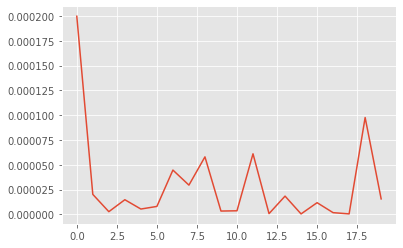

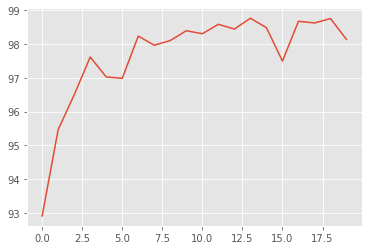

In [9]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################


plt.plot(loss_values)
plt.show()
plt.plot(val_accuracy)
plt.show()

# Test Model (20 Points)

In [19]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

y_real = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images,labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (torch.max(outputs.data, 1)[1]).cpu().numpy()
        correct += sum(predicted == labels.cpu().numpy()).item()
        total += labels.size(0)
        y_real.extend(labels.cpu().numpy())
        y_pred.extend(predicted)


In [20]:
print('accuracy :', correct/total)

accuracy : 0.9831


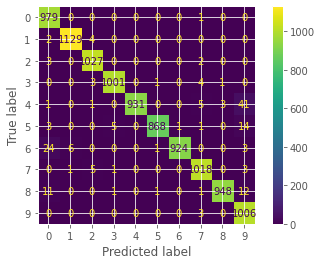

In [23]:
#confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_real, y_pred)).plot()
